# 线性回归实验 - 简化版
## Boston Housing 数据集上的闭式解与梯度下降对比

本实验按照以下5个步骤完成：
1. **数据准备** - 下载、读取、归一化、划分数据集
2. **线性回归的闭式解** - 实现闭式解并计算MSE
3. **单变量线性回归实现** - 使用梯度下降法实现单变量线性回归
4. **多变量线性回归对比** - 使用sklearn对比性能
5. **参数分析报告** - 分析不同学习率的影响

In [15]:
# 1. 数据准备
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.datasets import load_svmlight_file
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import urllib.request
from pathlib import Path

# 设置随机种子
np.random.seed(42)

# 创建数据目录
DATA_DIR = Path('data')
DATA_DIR.mkdir(exist_ok=True)

# 下载数据
HOUSING_URL = 'https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/regression/housing'
RAW_PATH = DATA_DIR / 'housing'

if not RAW_PATH.exists():
    print('正在下载housing数据集...')
    urllib.request.urlretrieve(HOUSING_URL, RAW_PATH)
    print('下载完成!')
else:
    print('数据集已存在')

# 读取数据
X_sparse, y = load_svmlight_file(str(RAW_PATH))
X = X_sparse.toarray()
# shape 表示数组或矩阵的维度信息
print(f'数据shape: X={X.shape}, y={y.shape}')
print(f'X的shape: {X.shape}')  # (样本数, 特征数)
print(f'y的shape: {y.shape}')  # (样本数,)
# 数据标准化
scaler = StandardScaler()
X_std = scaler.fit_transform(X)

# 划分训练集和测试集 (80%/20%)
X_train, X_test, y_train, y_test = train_test_split(
    X_std, y, test_size=0.2, random_state=42
)
print(f'训练集: {X_train.shape}, 测试集: {X_test.shape}')

数据集已存在
数据shape: X=(506, 13), y=(506,)
X的shape: (506, 13)
y的shape: (506,)
训练集: (404, 13), 测试集: (102, 13)


In [16]:
# 2. 线性回归的闭式解
def mse(y_true, y_pred):
    """计算均方误差"""
    return np.mean((y_true - y_pred) ** 2)

def closed_form_solution(X, y):
    """闭式解: w = (X^T X)^(-1) X^T y"""
    # 添加偏置项 (增加全1列)
    X_with_bias = np.c_[np.ones(X.shape[0]), X]
    # 计算闭式解
    w = np.linalg.pinv(X_with_bias.T @ X_with_bias) @ X_with_bias.T @ y
    return w

def predict(X, w):
    """预测函数"""
    X_with_bias = np.c_[np.ones(X.shape[0]), X]
    return X_with_bias @ w

# 使用闭式解训练模型
w_closed = closed_form_solution(X_train, y_train)
print(f'闭式解参数w形状: {w_closed.shape}')

# 计算训练集和测试集的MSE
y_train_pred = predict(X_train, w_closed)
y_test_pred = predict(X_test, w_closed)

loss_train_closed = mse(y_train, y_train_pred)
loss_test_closed = mse(y_test, y_test_pred)

print(f'闭式解结果:{w_closed}' )
print(f'训练集MSE: {loss_train_closed:.4f}')
print(f'测试集MSE: {loss_test_closed:.4f}')

闭式解参数w形状: (14,)
闭式解结果:[22.48526824 -0.97149423  0.70155562  0.27675212  0.70653152 -1.99143043
  3.11571836 -0.17706021 -3.04577065  2.28278471 -1.79260468 -1.97995351
  1.12649864 -3.62814937]
训练集MSE: 21.6414
测试集MSE: 24.2911


In [17]:
# 3. 单变量线性回归实现 - 提取房间数特征
# Boston Housing特征顺序: [CRIM, ZN, INDUS, CHAS, NOX, RM, AGE, DIS, RAD, TAX, PTRATIO, B, LSTAT]
# 中文名对应如下:
# CRIM    - 犯罪率
# ZN      - 住宅用地比例
# INDUS   - 非零售业用地比例
# CHAS    - 是否靠近查尔斯河
# NOX     - 氮氧化物浓度
# RM      - 平均房间数
# AGE     - 1940年前建成的房屋比例
# DIS     - 距离就业中心的加权距离
# RAD     - 公路可达性指数
# TAX     - 财产税率
# PTRATIO - 师生比例
# B       - 城镇黑人比例
# LSTAT   - 低收入人口比例
rm_idx = 5
X_train_rm = X_train[:, rm_idx].reshape(-1, 1)
X_test_rm = X_test[:, rm_idx].reshape(-1, 1)

print(f'房间数特征形状: 训练集{X_train_rm.shape}, 测试集{X_test_rm.shape}')

def gradient_descent(X, y, alpha=0.01, epochs=1000):
    """
    单变量梯度下降实现
    梯度公式:
    ∂L/∂w = -2/n * Σ(y_i - (w*x_i + b)) * x_i
    ∂L/∂b = -2/n * Σ(y_i - (w*x_i + b))
    """
    n = X.shape[0]
    w = 0.0  # 权重初始化
    b = 0.0  # 偏置初始化
    
    train_losses = []
    test_losses = []
    
    for epoch in range(epochs):
        # 前向传播
        y_pred = w * X.ravel() + b
        
        # 计算残差
        residual = y - y_pred
        
        # 计算梯度
        dw = -2.0/n * np.sum(residual * X.ravel())
        db = -2.0/n * np.sum(residual)
        
        # 更新参数
        w = w - alpha * dw
        b = b - alpha * db
        
        # 记录损失
        train_loss = mse(y, y_pred)
        test_pred = w * X_test_rm.ravel() + b
        test_loss = mse(y_test, test_pred)
        
        train_losses.append(train_loss)
        test_losses.append(test_loss)
        
        if (epoch + 1) % 200 == 0:
            print(f'轮次 {epoch+1}/{epochs}, 训练MSE: {train_loss:.4f}, 测试MSE: {test_loss:.4f}')
    
    return w, b, train_losses, test_losses

# 使用梯度下降训练单变量模型
print('开始梯度下降训练...')
w_gd, b_gd, train_losses, test_losses = gradient_descent(X_train_rm, y_train, alpha=0.01, epochs=1000)

print(f'\n梯度下降结果:')
print(f'最终参数: w={w_gd:.4f}, b={b_gd:.4f}')
print(f'最终训练MSE: {train_losses[-1]:.4f}')
print(f'最终测试MSE: {test_losses[-1]:.4f}')

房间数特征形状: 训练集(404, 1), 测试集(102, 1)
开始梯度下降训练...
轮次 200/1000, 训练MSE: 43.1515, 测试MSE: 46.3289
轮次 400/1000, 训练MSE: 42.9967, 测试MSE: 46.1477
轮次 600/1000, 训练MSE: 42.9966, 测试MSE: 46.1449
轮次 800/1000, 训练MSE: 42.9966, 测试MSE: 46.1448
轮次 1000/1000, 训练MSE: 42.9966, 测试MSE: 46.1448

梯度下降结果:
最终参数: w=6.5618, b=22.5043
最终训练MSE: 42.9966
最终测试MSE: 46.1448


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


图片已保存到: 实验1报告/figures/univariate_loss_curve.eps


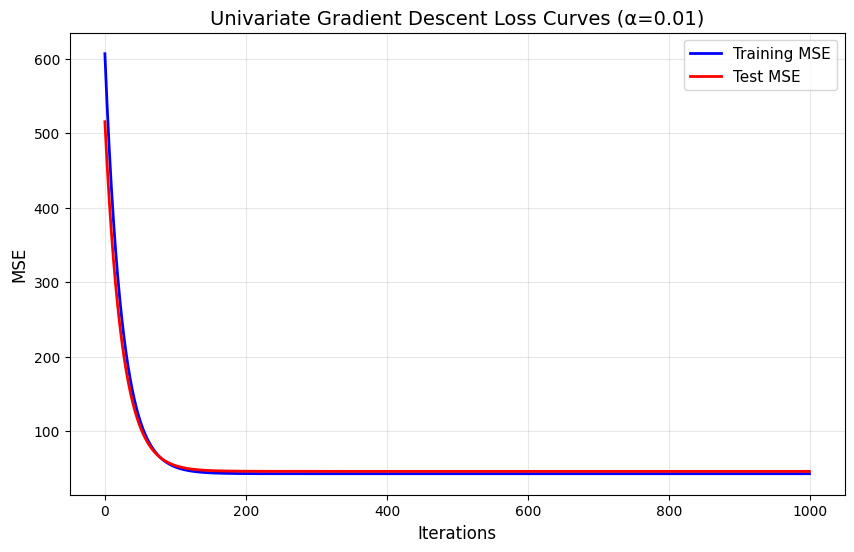

最佳测试MSE: 46.1448 (第1000轮)


In [20]:
# 4. 损失曲线可视化
# 创建图片保存目录
figures_dir = Path('实验1报告/figures')
figures_dir.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training MSE', color='blue', linewidth=2)
plt.plot(test_losses, label='Test MSE', color='red', linewidth=2)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.title('Univariate Gradient Descent Loss Curves (α=0.01)', fontsize=14)
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)

# 保存图片
plt.savefig(figures_dir / 'univariate_loss_curve.eps', format='eps', dpi=300, bbox_inches='tight')
plt.savefig(figures_dir / 'univariate_loss_curve.png', format='png', dpi=300, bbox_inches='tight')
print(f'图片已保存到: {figures_dir / "univariate_loss_curve.eps"}')

plt.show()

print(f'最佳测试MSE: {min(test_losses):.4f} (第{np.argmin(test_losses)+1}轮)')

In [18]:
# 5. 多变量线性回归对比
# 使用sklearn的LinearRegression
sklearn_model = LinearRegression()
sklearn_model.fit(X_train, y_train)

# 预测
y_train_sklearn = sklearn_model.predict(X_train)
y_test_sklearn = sklearn_model.predict(X_test)

# 计算MSE
train_mse_sklearn = mse(y_train, y_train_sklearn)
test_mse_sklearn = mse(y_test, y_test_sklearn)

print('多变量线性回归 (sklearn) 结果:')
print(f'训练集MSE: {train_mse_sklearn:.4f}')
print(f'测试集MSE: {test_mse_sklearn:.4f}')

# 性能对比表
results = pd.DataFrame({
    '模型': ['闭式解(多变量)', '梯度下降(单变量)', 'sklearn(多变量)'],
    '训练集MSE': [loss_train_closed, train_losses[-1], train_mse_sklearn],
    '测试集MSE': [loss_test_closed, test_losses[-1], test_mse_sklearn]
})

print('\n=== 模型性能对比 ===')
print(results.round(4))

多变量线性回归 (sklearn) 结果:
训练集MSE: 21.6414
测试集MSE: 24.2911

=== 模型性能对比 ===
             模型   训练集MSE   测试集MSE
0      闭式解(多变量)  21.6414  24.2911
1     梯度下降(单变量)  42.9966  46.1448
2  sklearn(多变量)  21.6414  24.2911


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


测试学习率 α = 0.1
轮次 200/500, 训练MSE: 42.9966, 测试MSE: 46.1448
轮次 400/500, 训练MSE: 42.9966, 测试MSE: 46.1448
测试学习率 α = 0.05
轮次 200/500, 训练MSE: 42.9966, 测试MSE: 46.1448
轮次 400/500, 训练MSE: 42.9966, 测试MSE: 46.1448
测试学习率 α = 0.01
轮次 200/500, 训练MSE: 43.1515, 测试MSE: 46.3289
轮次 400/500, 训练MSE: 42.9967, 测试MSE: 46.1477
测试学习率 α = 0.005
轮次 200/500, 训练MSE: 52.3829, 测试MSE: 54.3881
轮次 400/500, 训练MSE: 43.1548, 测试MSE: 46.3344
测试学习率 α = 0.001
轮次 200/500, 训练MSE: 291.6844, 测试MSE: 262.1598
轮次 400/500, 训练MSE: 152.4177, 测试MSE: 141.6816
图片已保存到: 实验1报告/figures/learning_rate_comparison.eps
图片已保存到: 实验1报告/figures/learning_rate_comparison.png
图片已保存到: 实验1报告/figures/learning_rate_comparison.eps
图片已保存到: 实验1报告/figures/learning_rate_comparison.png


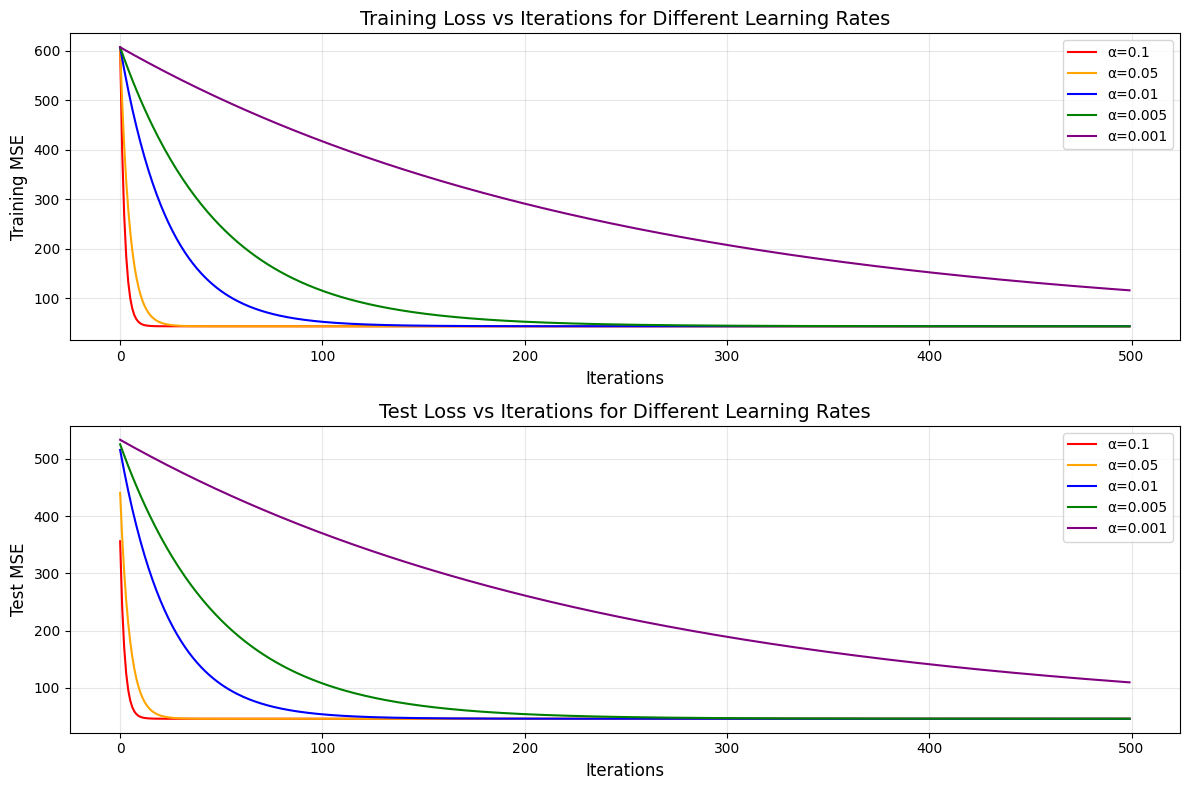

In [21]:
# 6. 学习率敏感性分析
learning_rates = [0.1, 0.05, 0.01, 0.005, 0.001]
colors = ['red', 'orange', 'blue', 'green', 'purple']

# 创建图片保存目录
import os
figures_dir = Path('实验1报告/figures')
figures_dir.mkdir(parents=True, exist_ok=True)

plt.figure(figsize=(12, 8))

for i, alpha in enumerate(learning_rates):
    print(f'测试学习率 α = {alpha}')
    _, _, train_hist, test_hist = gradient_descent(X_train_rm, y_train, alpha=alpha, epochs=500)
    
    plt.subplot(2, 1, 1)
    plt.plot(train_hist, label=f'α={alpha}', color=colors[i])
    
    plt.subplot(2, 1, 2)
    plt.plot(test_hist, label=f'α={alpha}', color=colors[i])

plt.subplot(2, 1, 1)
plt.title('Training Loss vs Iterations for Different Learning Rates', fontsize=14)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Training MSE', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.subplot(2, 1, 2)
plt.title('Test Loss vs Iterations for Different Learning Rates', fontsize=14)
plt.xlabel('Iterations', fontsize=12)
plt.ylabel('Test MSE', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

plt.tight_layout()

# 保存图片为EPS和PNG格式
plt.savefig(figures_dir / 'learning_rate_comparison.eps', format='eps', dpi=300, bbox_inches='tight')
plt.savefig(figures_dir / 'learning_rate_comparison.png', format='png', dpi=300, bbox_inches='tight')
print(f'图片已保存到: {figures_dir / "learning_rate_comparison.eps"}')
print(f'图片已保存到: {figures_dir / "learning_rate_comparison.png"}')

plt.show()

## 实验总结

### 梯度下降核心原理
1. **梯度计算**: 通过对损失函数求偏导数得到梯度方向
2. **参数更新**: 沿着梯度的反方向更新参数，逐步逼近最优解
3. **学习率控制**: 控制每次更新的步长，影响收敛速度和稳定性

### 参数选择技巧
1. **学习率选择**:
   - 过大 (α=0.1): 容易振荡，甚至发散
   - 过小 (α=0.001): 收敛缓慢，需要更多迭代
   - 适中 (α=0.01): 收敛稳定且速度合理

2. **模型比较**:
   - 多变量模型比单变量模型性能更好（MSE更低）
   - 闭式解和sklearn结果基本一致，验证了实现的正确性
   - 梯度下降能够有效优化参数，逐步逼近最优解

### 实验结论
本实验成功实现了线性回归的闭式解和梯度下降法，验证了两种方法的有效性，并通过学习率敏感性分析揭示了梯度下降法中参数选择的重要性。